In [16]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import *
import pickle 
import random
from time import sleep
import json
import requests
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans, MiniBatchKMeans
from nltk.tokenize import RegexpTokenizer

In [2]:
#отключение предупреждений
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
groups = pd.read_csv('ekb_community_stats.csv', header=None).values.ravel().tolist()

Для анализа было решено использовать часть данных, так как доступные мне вычислительные мощности не позволяют обрабатывать все предоставленные данные. Подвыборка выбиралась случайно.

In [ ]:
subsample_size = 20000
rand_groups = []
for i in range(subsample_size):
    group = random.choice(groups)
    rand_groups.append(group)
    groups.remove(group)  

In [ ]:
pickle.dump(rand_groups, open( "rand_groups_origin", "wb" ))
wall_get()

In [ ]:

def wall_get(id):
    """
    Keyword arguments:
    id - group's id
    
    returns [0] if error
    otherwise reterns [number of posts in group, last 100 posts]
    """
    first = "https://api.vk.com/method/wall.get?owner_id=-"
    last = "&count=100"
    data = requests.get(first + str(id) + last)
    datas = data.content.decode('utf8')
    data = json.loads(datas)
    try:
        data = data['response']
    except:
        return [0]
    return data[0], data[1:]

# Загрузка данных

В некоторых группах из выборки контент представлен в виде картинок. Было решено разделить группы, где информация передается с помощью картинок и где информация передается с помощью текста. Часть групп из воборки представляет собой закрытые, заблокированные сообщества, а так же сообщества, в которых недостаточно информации для анализа (мало постов). Такие группы удалялись. 

* av_word_len - средняя длина слова
* pic_groups_list - список идентификаторов групп с картинками
* text_groups_list список идентификаторов групп с текстом
* deleted_groups - список идентификаторов удаленных групп
* text_groups_dict словарь, содержащий список из постов групп. Ключем является идентефикатор группы

In [ ]:
"""av_word_len = 7
pic_groups_list = []
text_groups_list = []
text_groups_dict = {}
deleted_groups = []

j = 0"""

for id in rand_groups:

    posts = wall_get(id)
    
    
    if posts[0] <= 15: #если мало постов, удаляем группу
        j += 1
        deleted_groups.append(id)
        continue
      
    if posts[0] < 100: 
        n_posts = posts[0]
    else:
        n_posts = 100
    group_posts = []
    group_len = 0
    
    for post in posts[1]:
        new_post = ' '.join(post['text'].split('<br>'))
        group_len += len(new_post)
        group_posts.append(new_post)
    
    if float(group_len) / (n_posts * av_word_len) < 6.5: #Если количество слов на пост в группе < 6.5, добавляем в pic
        pic_groups_list.append(id)
    else:
        text_groups_dict[str(id)] = group_posts
        text_groups_list.append(id)
    
    j += 1
    print(j, id)


In [149]:
"""Во время загрузки данных у меня отключился интернет, 
которого не было в последствии весь день, поэтому для 
анализа использовалось меньше групп, чем указано выше."""

len(text_groups_list), len(pic_groups_list), len(deleted_groups)

(8082, 1474, 3434)

In [ ]:
#Сохранение данных
pickle.dump(deleted_groups, open( "deleted_groups", "wb" ))
pickle.dump(pic_groups_list, open( "pic_groups_list", "wb" ))
pickle.dump(text_groups_list, open( "text_groups_list", "wb" ))
pickle.dump(text_groups_dict, open( "text_groups_dict", "wb" ))

# Кластеризация групп с текстом

Для кластеризации групп с текстом было решено использовать алгоритм K-means. Все посты были лемматизированы. После, все посты из одной группы были склеены в один текст. После данные были преобразованы с помощью алгоритма tf-idf.

## Получение матрицы признаков

Для получения матрицы признаков можно использовать разные подходы. Далее будут опробованы два из них:

* tf-idf
* doc2vec

Но прежде, чем давать алгоритмам данные, их нужно обработать.

## Обработка данных

In [ ]:
#Лемматизация
m = Mystem()
keys = list(text_groups_dict.keys())
j = 0

for key in keys:
    for i in range(len(text_groups_dict[key])):
        text_groups_dict[key][i] = ''.join(m.lemmatize(text_groups_dict[key][i]))
    j += 1
    print(j, key)

In [ ]:
#Сохранение данных
pickle.dump(text_groups_dict, open( "text_groups_dict_lem", "wb" ))

In [ ]:
#Склейка всех постов в каждой группе
text_group_dict2 = {}
for key in keys:
    text_group_dict2[key] = ''.join((''.join(text_groups_dict[key])).split("\n"))       
        

In [ ]:
#Сохранение данных
pickle.dump(text_group_dict2, open( "text_group_dict_lem2", "wb" ))

In [3]:
#Загрузка данных
data_dict = pickle.load(open('text_group_dict_lem2', 'rb'))
data = list(data_dict.values())

In [4]:
#Загрузка стоп слов
file = open("stop_words.txt", encoding='utf-8')
stop_words = file.read().split("\n")
file.close()

In [ ]:
# Токенизация и удаление стоп слов
tokenizer = RegexpTokenizer(r'\w+')
tokenized_data = {}

for key in data_dict:
    tokens = tokenizer.tokenize(data_dict[key])
    stopped_tokens = [i for i in tokens if not i in stop_words]
    tokenized_data[key] = stopped_tokens

pickle.dump(tokenized_data, open('lemmatized_tokenized_text', 'wb'))

In [264]:
tokenized_data = pickle.load(open('lemmatized_tokenized_text', 'rb'))

## doc2vec

In [11]:
from gensim import corpora, models
from gensim.models import doc2vec
from collections import namedtuple


dictionary = corpora.Dictionary(list(tokenized_data.values()))
corpus = [dictionary.doc2bow(text) for text in list(tokenized_data.values())]



In [12]:
docs = []
docs_labels = list(tokenized_data.keys())
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, words in enumerate(list(tokenized_data.values())):
    tags = [i]
    docs.append(analyzedDocument(words, tags))

In [13]:
doc_model = doc2vec.Doc2Vec(documents=docs, window=10)

In [21]:
for i in range(5):
    rand_group = random.randint(0, 8083)
    print('-----------------\n', rand_group, 'vk.com/club' + docs_labels[rand_group])
    print(*np.array(doc_model.similar_by_vector(doc_model.docvecs[rand_group], topn=4))[:,0])
    print('-----------------\n2 most similar groups:\n')
    top_n = doc_model.docvecs.most_similar(rand_group, topn=2)
    for i in top_n:
        ind = int(i[0])
        print(i[0], 'vk.com/club' + docs_labels[i[0]], i[1], 
              *np.array(doc_model.similar_by_vector(doc_model.docvecs[ind], topn=4))[:,0])


-----------------
 596 vk.com/club53503880
просто мочь хотеть бояться
-----------------
2 most similar groups:

3295 vk.com/club43005314 0.5198018550872803 просто думать значит любить
7116 vk.com/club50101397 0.4754263758659363 заставлять нихера размышлять успех
-----------------
 655 vk.com/club10285494
оборотень разбойник криминальный грабитель
-----------------
2 most similar groups:

5690 vk.com/club36647917 0.7694495916366577 оборотень приключение похищать чудовище
1872 vk.com/club42788054 0.758505642414093 оборотень барри криминальный детектив
-----------------
 1687 vk.com/club41293763
Neurohop Glitch glitchhop idm
-----------------
2 most similar groups:

2215 vk.com/club51207325 0.7073994278907776 The Hill Remix From
1296 vk.com/club19492084 0.6798967719078064 The Remix Hill photographed
-----------------
 6651 vk.com/club79580527
ресничка длинныересница ламинирование ресница
-----------------
2 most similar groups:

2408 vk.com/club21885045 0.6392230987548828 ресница ресничка

In [22]:
doc2vec_matrix = np.array(doc_model.docvecs)

## tf-idf


In [23]:
vectorizer = TfidfVectorizer(
            max_df=0.5,
            max_features=5000,
            min_df=2,
            stop_words=stop_words,
            analyzer="word")

In [25]:
#Преобразование данных с помощью tf-idf
tf_matrix = vectorizer.fit_transform(data)
tf_matrix = tf_matrix.toarray()
keys = list(data_dict.keys())

# Кластеризация

## Иерархическая кластеризация

In [543]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

class linkage_cluser:
    def __init__(self, data, keys, method='complete', pd_metric='euclidean', metric='euclidean'):
        self.data = data
        self.keys = keys
        self.method = method
        self.pd_metric = pd_metric
        self.metric = metric
        self.dist_matrix = squareform(pdist(data, metric=pd_metric))
        self.linkage_matrix = linkage(dist_matrix, method=method, metric=metric)
    
    def get_clusters(self, clusternum):
        clustdict = {i:[i] for i in xrange(len(link_matrix)+1)}
        for i in range(len(self.linkage_matrix)-clusternum+1):
            clust1= int(self.linkage_matrix[i][0])
            clust2= int(self.linkage_matrix[i][1])
            clustdict[max(clustdict)+1] = clustdict[clust1] + clustdict[clust2]
            del clustdict[clust1], clustdict[clust2]
        return clustdict

    def get_labels(self, clusternum):
        labels = [0] * len(data)
        clusters = self.get_clusters(clusternum)
        for clust in clusters:
            for i in clust:
                labels[i] = clust
        return labels

In [544]:
dist_tf_matrix = pdist(tf_matrix)
tf_sqfrm = squareform(dist_tf_matrix)
link_tf_matrix = linkage(tf_sqfrm, method='complete')

In [558]:
lalka = linkage_tf_complete.get_clusters(60)

In [549]:
linkage_tf_complete = linkage_cluser(data=tf_matrix, keys=keys, method='complete',
                                     pd_metric='euclidean',metric='euclidean')

KeyError: 0

In [562]:
s = []
for key in lalka:
    s.append(len(lalka[key]))
for i in lalka[list(lalka.keys())[1]]:
    print('club' + keys[i])

club55552579
club55387604
club42977757
club31211063
club31403763
club42082503
club74362568


In [ ]:
for key in clustdict:
    print(len(clustdict[key]))

In [34]:
from sklearn.metrics import calinski_harabaz_score


calinski = []
i = 2
for key in labels_dict:
    calinski.append(calinski_harabaz_score(tf_matrix, labels_dict[key]))
    
"""km_dict = {}
labels_dict = {}"""
"""for num_clust in range(100, 102):
    km = KMeans(n_clusters=num_clust, n_init=1)
    km.fit(tf_matrix)
    km_dict[num_clust] = km
    labels_dict[num_clust] = km.labels_
    print(num_clust)"""

'for num_clust in range(100, 102):\n    km = KMeans(n_clusters=num_clust, n_init=1)\n    km.fit(tf_matrix)\n    km_dict[num_clust] = km\n    labels_dict[num_clust] = km.labels_\n    print(num_clust)'

In [36]:
len(list(range(2,50)) + [])

50

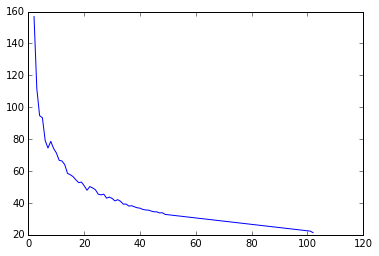

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(list(range(2,50))+[101,102], calinski)
plt.show()

In [111]:
n_clusters = 20
km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1)
                         

In [112]:
km.fit(tf_matrix)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [113]:
terms = vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: руб платье наличие размер заказ цвет доставка скидка ткань см
Cluster 1: iphone игра apple сервер смартфон samsung приложение android устройство galaxy
Cluster 2: твой любовь мужчина женщина душа сердце счастие никто глаз рядом
Cluster 3: секс парень мужчина искать женщина анон член анонимно собака познакомиться
Cluster 4: бизнес сайт зарабатывать доход компания интернет деньги рубль клиент проект
Cluster 5: добавлять квартира сайт рубль видео конкурс руб тело привет игра
Cluster 6: масло ложка сахар яйцо соль добавлять тесто ингредиент мука перец
Cluster 7: remix mix original house feat dj bass drum techno trance
Cluster 8: екатеринбург конкурс фестиваль программа проект занятие участие ул язык участник
Cluster 9: упражнение женщина мышца книга энергия мужчина сила отношение организм вода
Cluster 10: заказ доставка заказывать скидка наличие товар рубль подарок topic размер
Cluster 11: волос кожа наращивание ресница процедура бровь маска масло макияж ноготь
Cluster 12: свадь

Как можно заметить, k-means довольно неплохо справляется с кластеризацией текста. Кластеры, полученные с помощью такого подхода вполне можно назвать тематическими. Тем не менее, сложность заключается в выборе кластеров. Поставив слишком большое количество кластеров, мы можем получить повторяющиеся кластеры, а поставив маленькое, можем не получить важной информации.

# Иерархическая кластеризация с помощью k-means

Для того, чтобы устранить недостаток, описанный выше, было решено запустить k-means делить данные рекурсивно по два кластера. Таким образом можно построить дерево, в узлах которой будут данные о конкретных кластерах. Критерием остановки будет служить максимальный размер кластера (max_cl_size). Если кластер меньше максимального размера кластера, то происходит выход из рекурсии.

Данные о кластерах:

* data - векторы, полученные из матрицы X
* level - глубина дерева, на которой лежит кластер
* size - размер кластера
* words - ключевые слова кластера
* groupd - идентефикаторы групп кластера
* center - центр кластера

Позже, для каждого кластера будет добавлено еще одно поле:

* ind - индекс кластера на определенной глубине


In [ ]:
def get_clust_words(k_means, ind, num=10):
    """
    Keyword arguments:
    k_means - k-means object
    ind - cluster's index
    num - numbers of words to return
    
    returns num ind-th cluster's key words
    """
    terms = vectorizer.get_feature_names()
    order_centroids = k_means.cluster_centers_.argsort()[:, ::-1]
    
    words = []
    for i in order_centroids[ind, :num]:
        words.append(terms[i])
    return words


def recurent_km(data, groups, cluster_words=None, center=None, max_cl_size=400, k=1, stage=0):    
    global max_level
    if stage == 0:
        max_level = 0
    if max_level < stage:
        max_level = stage
    clust_dict = {}
    clust_dict['data'] = data
    clust_dict['level'] = stage
    clust_dict['size'] = len(data)
    clust_dict['words'] = cluster_words
    clust_dict['groups'] = groups
    clust_dict['center'] = center
    
    
    if len(data) < max_cl_size:
        list_tree[k-1] = clust_dict
        return
    
    list_tree[k-1] = clust_dict
    
    km = KMeans(n_clusters=2, init='k-means++', n_init=1)
    
    km.fit(data) 
    data1 = []
    data2 = []
    groups1 = []
    groups2 = []
    center1 = km.cluster_centers_[0]
    center2 = km.cluster_centers_[1]
    cluster_words1 = get_clust_words(km, 0)
    cluster_words2 = get_clust_words(km, 1)
    
    labels = km.labels_
    for i in range(len(labels)):
        if labels[i] == 0:
            data1.append(data[i])
            groups1.append(groups[i])
        else:
            data2.append(data[i])
            groups2.append(groups[i])
    recurent_km(data=data1, groups=groups1, cluster_words=cluster_words1, center=center1, k=2*k, stage=stage+1)
    recurent_km(data=data2, groups=groups2, cluster_words=cluster_words2, center=center2, k=2*k + 1, stage=stage+1)

list_num = 2**23
list_tree = [0] * list_num      #лист, куда будут записываться кластера (взят с запасом)
max_cl_size = 400               #максимальный размер кластера
groups = list(data_dict.keys()) # идентефикаторы групп
recurent_km(data=tf_matrix, groups=groups)

In [253]:
print("Глубина дерева:", max_level)

Глубина дерева: 15


In [72]:
#Разделение на уровни и присвоение каждому кластеру индекса

levels = []

for i in range(max_level + 2):
    levels.append(list_tree[(2**i)-1: 2**(i+1) - 1])

for level in levels[1:]:
    for i in range(len(level)):
        if level[i] != 0:
            level[i]['ind'] = level.index(level[i])

In [64]:
#Нахождение конечных кластеров
down_cl = []
for level in levels[1:]:
    for cluster in level:
        if cluster != 0:
            if cluster['size'] < max_cl_size:
                down_cl.append(cluster)

Получив дерево кластеров, можно посмотреть на конечные кластеры (кластеры, размер которах не превышает max_cl_size) и решить, удовлетворяют ли эти кластерам заданным требованиям. Если конечные кластеры можно разделить на подклассы, то следует запустить алгоритм, уменьшив max_cl_size. Если конечные кластеры повторяют друг друга, можно, с помощью вспомогательной функции получить их родителя.

In [105]:
def get_ancestor(cluster):
    """
    Keyword arguments:
    cluster - cluster's data from list_tree
    
    returns cluster's ancestor
    """
    level = levels[cluster['level'] - 1]
    ind = cluster['ind'] // 2
    
    return level[ind] 

def sort_groups(cluster):
     """
    Keyword arguments:
    cluster - cluster's data from list_tree
    
    returns sorted by the distance frome the center groups
    """
    center = cluster['center']
    groups = cluster['groups']
    data = cluster['data']
    dist_matrix = []
    sorted_groups = []
    for vec in data:
        dist_matrix.append(euclidean(vec, center))
    sorted_ind = np.array(dist_matrix).argsort()
    for ind in sorted_ind:
        sorted_groups.append(groups[ind])
    return sorted_groups
    

Ниже можно увидеть для каждого кластера его размер, глубину на которой он находится, его индекс и ключевые слова

In [255]:
print("Количество коечных кластеров:",len(down_cl), '\n')

for i in down_cl:
    print(i['size'], i['level'], i['ind'], *i['words'])

Количество коечных кластеров: 42 

395 2 1 свадьба свадебный невеста фотограф фотосессия съемка wedding прическа макияж платье
7 3 4 утро слабо осень ночь сердце твой верить музыка спокойный любовь
204 3 6 книга фильм бог история земля любовь женщина смерть жанр сила
205 4 3 масло мышца сахар упражнение яйцо ложка тренировка соль добавлять ингредиент
15 4 10 бог божий господь любовь молитва преподобный иоанн твой христос святой
138 4 14 малыш вода масло мама ложка организм кожа упражнение сахар добавлять
330 4 15 деньги женщина мужчина бизнес отношение цель энергия книга любовь проблема
142 5 0 секс искать парень познакомиться член вирт анон привет встреча куни
251 5 2 руб iphone чехол apple samsung продавать рубль размер смартфон наличие
140 6 6 платье наличие размер заказ цвет руб ткань одежда юбка скидка
383 6 9 квартира сайт компания интернет рубль доход зарабатывать бизнес руб проект
267 6 10 концерт билет альбом песня музыка фестиваль клуб рок екатеринбург москва
149 6 11 альбом 

Как можно заметить, следующие кластера очень похожи между собой, поэтому мы можем посмотреть на их предка

* 240 6 44 твой любовь душа сердце никто скучать рядом счастие прощать уходить"
* 239 6 45 твой любовь мужчина женщина сердце счастие душа счастливый глаз никто

In [101]:
print(*get_ancestor(levels[6][44])['words'])
print(*get_ancestor(levels[6][45])['words'])

твой любовь сердце душа мужчина счастие женщина никто рядом счастливый
твой любовь сердце душа мужчина счастие женщина никто рядом счастливый


Ниже предоставлены ключевые слова по каждому кластеру и по 3 группы, наиболее приближенные к центру кластера


In [110]:
for cluster in down_cl:
    groups = sort_groups(cluster)
    print(*cluster['words'])
    print('\nvk.com/club' + groups[0])
    print('vk.com/club' + groups[1])
    print('vk.com/club' + groups[2], '\n')
    

свадьба свадебный невеста фотограф фотосессия съемка wedding прическа макияж платье

vk.com/club32768467
vk.com/club24251666
vk.com/club34752316 

утро слабо осень ночь сердце твой верить музыка спокойный любовь

vk.com/club30790069
vk.com/club46837498
vk.com/club45192348 

книга фильм бог история земля любовь женщина смерть жанр сила

vk.com/club51682933
vk.com/club45270133
vk.com/club18206367 

масло мышца сахар упражнение яйцо ложка тренировка соль добавлять ингредиент

vk.com/club54725864
vk.com/club48946342
vk.com/club32455286 

бог божий господь любовь молитва преподобный иоанн твой христос святой

vk.com/club16838988
vk.com/club29599237
vk.com/club36825554 

малыш вода масло мама ложка организм кожа упражнение сахар добавлять

vk.com/club82274301
vk.com/club54616802
vk.com/club42082503 

деньги женщина мужчина бизнес отношение цель энергия книга любовь проблема

vk.com/club54087668
vk.com/club47211280
vk.com/club51563246 

секс искать парень познакомиться член вирт анон привет в

In [480]:
'club' + doc_labels[5916]

'club40639202'

In [477]:
doc_model.docvecs.most_similar(0, topn=1000)#1380, 0.6308777332305908

[(1380, 0.6308777332305908),
 (5792, 0.6292417049407959),
 (3759, 0.6116605997085571),
 (2092, 0.6112592220306396),
 (8054, 0.6099122762680054),
 (1966, 0.6016685962677002),
 (5915, 0.6014361381530762),
 (7223, 0.5930748581886292),
 (5505, 0.5860998630523682),
 (3682, 0.5756050944328308),
 (4486, 0.5694819688796997),
 (6729, 0.5647456645965576),
 (6657, 0.5614608526229858),
 (6090, 0.5575432777404785),
 (1710, 0.5427920818328857),
 (53, 0.5414199829101562),
 (729, 0.5391100645065308),
 (7803, 0.5314836502075195),
 (6624, 0.5289008617401123),
 (5576, 0.5257525444030762),
 (3086, 0.5138784646987915),
 (1692, 0.5120785236358643),
 (2852, 0.5091587901115417),
 (3365, 0.5082088708877563),
 (7404, 0.507195770740509),
 (2624, 0.5023456811904907),
 (1075, 0.5014996528625488),
 (4586, 0.4992123544216156),
 (767, 0.48582321405410767),
 (2807, 0.4828990697860718),
 (4007, 0.48159128427505493),
 (1366, 0.48117297887802124),
 (719, 0.4791279137134552),
 (6451, 0.4789407253265381),
 (879, 0.47875684

## doc2vec

In [507]:
# cosine -> average&cosine = bad

dist_doc2vec = pdist(doc2vec_matrix, metric='cosine')
doc2vec_sqfrm = squareform(dist_doc2vec)
link_doc2vec_matrix = linkage(doc2vec_sqfrm, method='average', metric='cosine')

In [520]:
link_doc2vec_clusts = get_clusters(link_doc2vec_matrix, 30)

In [527]:
s = []
for key in link_doc2vec_clusts:
    s.append(len(link_doc2vec_clusts[key]))
for i in link_doc2vec_clusts[list(link_doc2vec_clusts.keys())[0]]:
    print('club' + doc_labels[i])

club54845383
club66534391
club59793674
club6970962
club52069260
club45775247
club62018532
club41783420
club322529
club66411312
club15082659
club61632438
club46594225
club24314256
club34241463
club42745525
club59038535
club19274158
club79141188
club10604190
club72564354


# Кластеризация групп с картинками

Изначально, мной была допущена ошибка, из-за которой лист pic_groups_list записались группы, содержащие музыку. Ниже группы из pic_groups_list были разделены на music (группы с музыкой) и pic (группы с картинками).

Первый кластер (music) можно объеденить с аналогичным кластеров (кластер, ключевыми словами которого являются музыкальные жанры). Второй же (pic) было решено оставить, так как анализ картинок - довольно трудоемкая задача, которая, в контексте данного задания, не принесет большой пользы.

In [245]:
def get_wall2(id):
    first = "https://api.vk.com/method/wall.get?owner_id=-"
    last = "&count=100"
    data = requests.get(first + str(id) + last)
    datas = data.content.decode('utf8')
    data = json.loads(datas)
    try:
        data = data['response']
    except:
        data = 0
    return data

In [ ]:
pic = []
music = []
bad_id = []
j = 0
for id in pic_groups_list:
    wall = get_wall2(id)
    audio = 0
    if wall == 0:
        bad_id.append(id)
    else:
        for i in range(2, len(wall) - 2):
            try:
                attachments =  wall[i]['attachments']
                for attach in attachments:
                    try:
                        _ = attach['audio']
                        audio += 1
                    except:
                        continue 
            except:
                continue
                
        if audio/(len(wall) - 2) < 1:
            pic.append(id)
        else:
            music.append(id)

In [256]:
print(len(music), len(pic))

109 1364
